In [ ]:
import pandas as pd
import numpy as np
import plotnine as pn
from matplotlib import pyplot as plt
import plotly.express as px

# Warhammer: The Old World
## A Statistical Analysis of Tournament Win Rates
### By: Jacob M. Lundeen

I was first introduced to Games Workshop's (GW) Warhammer: Fantasy Battles (WFB) back in the mid 1990's in Fairfax, Virginia. I was in the fifth or sixth grade and wondered by a GW store with my parents. I convinced them to take me in and managed to walk out with my first eight pack of skeleton warriors (Undead for life!). Over the next couple of years I would acquire a healthy collection of miniatures that was significantly boosted by my winning a White Dwarf survey contest and bringing home $5k worth of Tyranids, Dogs of War, Blood Bowl, and a others. As I grew up, I lost interest in WFB for various reasons as a lot of kids do. However, with WFB being reborn as Warhammer: The Old World (TOW) earlier this year, and me as an adult able to afford this hobby, I jumped back in and haven't looked back.

Since I've rediscovered TOW, I've wanted to combine TOW with one of my other passions, Data Science. With TOW only having returned earlier this year, the available data set is still immature. As we'll see there are many instances of incredible small sample sizes when we look at specific faction versus faction. But my hope is this will give an interesting look into where the game currently stands, where it might need to go, and lead to other interesting questions to ask and explore.

In [127]:
tow = pd.read_excel('tow.xlsx')

In [128]:
tow.head()

,pairing_id,round,player1_name,player2_name,player1_result,player2_result,player1_score,player2_score,event_name,event_date,...,Points,Rounds,Ruleset,Full Data,Mirror Match?,Players,Legacy Lists,Allies,Rule of 3,Faction v Faction
0,405136,1,Ridvan Martinez,David Clarke,2.0,0.0,1770.0,901.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,N,N,12,Y,NaN,NaN,Wood Elf Realms
1,405155,1,Mike Summerfeldt,Russ Jeffery,0.0,2.0,450.0,1920.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Warriors of ChaosWood Elf Realms
2,405171,1,Brandon Deamer,Eddie Crampton,2.0,0.0,1745.0,1531.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Tomb Kings of KhemriHigh Elf Realms
3,405192,1,taylor hanson,Luka Pavicevic,0.0,2.0,867.0,1205.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Kingdom of BretonniaDwarfen Mountain Holds
4,405199,1,Eric Locke,Danny Stewart,0.0,2.0,815.0,1206.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,N,N,12,Y,NaN,NaN,Ogre Kingdoms


In [129]:
tow.shape

(2030, 31)

In [130]:
tow = tow.query("`Mirror Match?` == 'N'")
tow.shape

(1836, 31)

In [131]:
tow = tow.query("`Full Data` == 'Y'")
tow.shape

(1616, 31)

In [132]:
tow = tow.query("Players >= 10")
tow.shape

(1429, 31)

In [133]:
tow_2000 = tow.query('Points == 2000')
tow_2000.shape

(755, 31)

In [134]:
display(tow_2000)

,pairing_id,round,player1_name,player2_name,player1_result,player2_result,player1_score,player2_score,event_name,event_date,...,Points,Rounds,Ruleset,Full Data,Mirror Match?,Players,Legacy Lists,Allies,Rule of 3,Faction v Faction
1,405155,1,Mike Summerfeldt,Russ Jeffery,0.0,2.0,450.0,1920.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Warriors of ChaosWood Elf Realms
2,405171,1,Brandon Deamer,Eddie Crampton,2.0,0.0,1745.0,1531.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Tomb Kings of KhemriHigh Elf Realms
3,405192,1,taylor hanson,Luka Pavicevic,0.0,2.0,867.0,1205.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Kingdom of BretonniaDwarfen Mountain Holds
6,405234,2,Danny Stewart,Luka Pavicevic,2.0,0.0,2000.0,0.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Ogre KingdomsDwarfen Mountain Holds
7,405244,2,Ridvan Martinez,Brandon Deamer,2.0,0.0,1466.0,900.0,The First Old World Forgemaster,2024-02-03 14:00:00,...,2000,3,v1.1,Y,N,12,Y,NaN,NaN,Wood Elf RealmsTomb Kings of Khemri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,431012,3,Zach Thompson,Jordon Weatherwax,0.0,2.0,10.0,23.0,WARHAMMER THE OLD WORLD RTT Presented by SQUA...,2024-04-20 15:30:00,...,2000,3,v1.2,Y,N,24,Y,NaN,NaN,Wood Elf RealmsTomb Kings of Khemri
2010,431036,3,Daniel LaBore,Steven Knott,0.0,2.0,1.0,25.0,WARHAMMER THE OLD WORLD RTT Presented by SQUA...,2024-04-20 15:30:00,...,2000,3,v1.2,Y,N,24,Y,NaN,NaN,Empire of ManChaos Dwarfs
2012,431073,3,Craig Stueber,Kris Jones,2.0,0.0,18.0,9.0,WARHAMMER THE OLD WORLD RTT Presented by SQUA...,2024-04-20 15:30:00,...,2000,3,v1.2,Y,N,24,Y,NaN,NaN,Wood Elf RealmsEmpire of Man
2013,431088,3,Todd Wiatt,Austin Wingfield,0.0,2.0,0.0,24.0,WARHAMMER THE OLD WORLD RTT Presented by SQUA...,2024-04-20 15:30:00,...,2000,3,v1.2,Y,N,24,Y,NaN,NaN,Warriors of ChaosBeastmen Brayherds


In [135]:
player1_db = tow_2000[['player1_faction', 'player2_faction' ,'player1_result']] .rename(columns={"player1_faction": "player_faction", "player2_faction" : "opponent_faction", "player1_result" : "result"})
player2_db = tow_2000[['player2_faction', 'player1_faction', 'player2_result']].rename(columns={"player2_faction": "player_faction", "player1_faction" : "opponent_faction", "player2_result" : "result"})
player_db = pd.concat([player1_db, player2_db], ignore_index=True)
display(player_db)

,player_faction,opponent_faction,result
0,Warriors of Chaos,Wood Elf Realms,0.0
1,Tomb Kings of Khemri,High Elf Realms,2.0
2,Kingdom of Bretonnia,Dwarfen Mountain Holds,0.0
3,Ogre Kingdoms,Dwarfen Mountain Holds,2.0
4,Wood Elf Realms,Tomb Kings of Khemri,2.0
...,...,...,...
1505,Tomb Kings of Khemri,Wood Elf Realms,2.0
1506,Chaos Dwarfs,Empire of Man,2.0
1507,Empire of Man,Wood Elf Realms,0.0
1508,Beastmen Brayherds,Warriors of Chaos,2.0


In [141]:
tk_db = player_db.query("player_faction == 'Tomb Kings of Khemri'").groupby(['opponent_faction'])['player_faction'].count()
tk_wins = player_db.query("player_faction == 'Tomb Kings of Khemri' & result == 2.0").groupby('opponent_faction')['result'].count()
tk_db = pd.concat([tk_db, tk_wins], axis=1).rename(columns={"player_faction": "games_played", "result": "wins"})
tk_db['win_rate_by_faction'] = tk_db['wins']/tk_db['games_played']
tk_db = tk_db.reset_index()
tk_db = tk_db.fillna(0)
tk_db

,opponent_faction,games_played,wins,win_rate_by_faction
0,Beastmen Brayherds,8,3.0,0.375000
1,Chaos Dwarfs,3,2.0,0.666667
2,Daemons of Chaos,5,2.0,0.400000
3,Dark Elves,2,2.0,1.000000
4,Dwarfen Mountain Holds,10,6.0,0.600000
5,Empire of Man,18,14.0,0.777778
6,High Elf Realms,9,4.0,0.444444
7,Kingdom of Bretonnia,26,14.0,0.538462
8,Lizardmen,4,2.0,0.500000
9,Ogre Kingdoms,3,0.0,0.000000


In [137]:
tk_db['games_played'].sum()

154

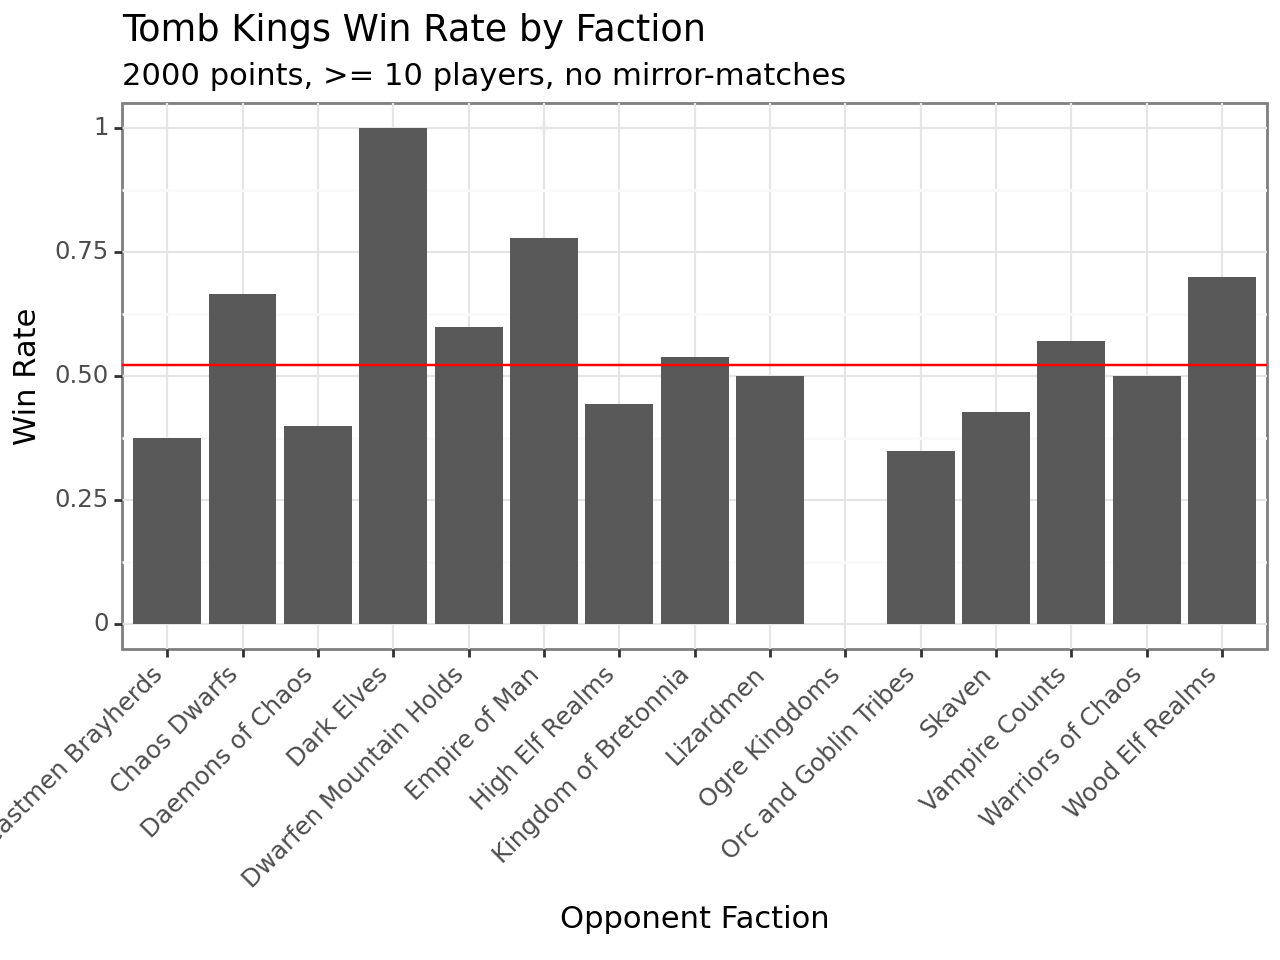

<Figure Size: (640 x 480)>

In [142]:
pn.ggplot(tk_db) + pn.aes(x='opponent_faction', y='win_rate_by_faction') + pn.geom_bar(stat = 'identity') + pn.geom_abline(intercept=tk_db['win_rate_by_faction'].mean(), slope=0, color="red") + pn.theme_bw() + pn.theme(axis_text_x = pn.element_text(angle=45, hjust=1)) + pn.labs(title="Tomb Kings Win Rate by Faction", subtitle='2000 points, >= 10 players, no mirror-matches', x="Opponent Faction", y='Win Rate')



In [139]:
tk_db['win_rate_by_faction'].mean()

0.5608821733821734